<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182786979" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182712552" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/luminlab/ber-curation?scriptVersionId=182257992" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Details of Steps can be found on Google Slides via:¶

https://docs.google.com/presentation/d/1sb3QkXiYooHqi3p-tkGVUqwqFKd-601_pzU96W1drw0/edit?usp=sharing

In [3]:
from kaggle_secrets import UserSecretsClient
wandb_key_label = "WANDB_KEY"
wandb_key= UserSecretsClient().get_secret(wandb_key_label)

In [ ]:
import git
git.Repo.clone_from('https://github.com/Lumin-Lab/BerCuration', '/kaggle/working/scarf')

In [3]:
!pip install -r /kaggle/working/scarf/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 12.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.3/352.3 kB 3.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
import os
def save_csv_file(df, path):
    dir_name = os.path.dirname(path)
    if dir_name:
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
    df.to_csv(path, index=False)

In [7]:
import pandas as pd
df = pd.read_csv("/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv")

/tmp/ipykernel_34/2556053210.py:2: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv")


In [6]:
n_splits = 5
output_dir = "/kaggle/working/output"
config_dir="/kaggle/working/scarf/configs"
scarf_model_name = "scarf"
mlp_model_name = "mlp"

In [12]:
from sklearn.model_selection import KFold
import os
kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)
for i, (train_index, test_index) in enumerate(kf.split(df)):
    save_csv_file(df.iloc[train_index], f"{output_dir}/split_{i+1}/raw_train.csv")
    save_csv_file(df.iloc[test_index], f"{output_dir}/split_{i+1}/raw_test.csv")

In [21]:
command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "/kaggle/working/scarf/configs" \
      --output_dir="{output_dir}" \
      --data_path "/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv" \
      --output_csv_name "processed" \
      --is_train
    """
os.system(command)

0

In [23]:
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "/kaggle/working/scarf/configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/raw_train.csv" \
      --output_csv_name "processed_train" \
      --is_train
    """
    os.system(command)
    command = f"""
    python /kaggle/working/scarf/get_processed_dataset.py \
      --config_dir "/kaggle/working/scarf/configs" \
      --output_dir "{output_dir}/split_{i+1}" \
      --data_path "{output_dir}/split_{i+1}/raw_test.csv" \
      --output_csv_name "processed_test"
    """
    os.system(command)

**Train the SCARF Encoder on the Train Dataset**

In [24]:
scarf_batch_size = 32
scarf_epochs = 25
scarf_lr = 3e-5
scarf_emb_dim = 32
scarf_encoder_depth = 3
scarf_corruption_rate=0.3

In [ ]:
import os
"""The trained scarf model is saved in 
/kaggle/working/output/split_{split}/scarf.pt if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/run_scarf.py\
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --train_data_path="{output_dir}/split_{i+1}/processed_train.csv"\
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name="{scarf_model_name}" \
      --corruption_rate={scarf_corruption_rate} \
      --wandb_project_name='SCARF_Project' \
      --wandb_entity='urbancomp' \
      --wandb_key='{wandb_key}'
    """

    os.system(command)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.0
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240611_055904-39d63qlf
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run SCARF_Project
wandb: ⭐️ View project at https://wandb.ai/urbancomp/Scarf
wandb: 🚀 View run at https://wandb.ai/urbancomp/Scarf/runs/39d63qlf


Epoch [1/25] - Train Loss: 2.950
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [2/25] - Train Loss: 2.916
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [3/25] - Train Loss: 2.964
Epoch [4/25] - Train Loss: 2.940
Epoch [5/25] - Train Loss: 2.894
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [6/25] - Train Loss: 2.917
Epoch [7/25] - Train Loss: 2.849
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [8/25] - Train Loss: 2.819
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [9/25] - Train Loss: 2.962
Epoch [10/25] - Train Loss: 2.839
Epoch [11/25] - Train Loss: 2.899
Epoch [12/25] - Train Loss: 2.860
Epoch [13/25] - Train Loss: 2.904
Epoch [14/25] - Train Loss: 2.862
Epoch [15/25] - Train Loss: 2.846
Epoch [16/25] - Train Loss: 2.829
Epoch [17/25] - Train Loss: 2.905
Epoch [18/25] - Train Loss: 2.796
Model saved at /kaggle/working/output/split_1/scarf.pt
Epoch [19/25] - Train Loss: 2.870
Epoch [20/25] - Train Loss: 2.920

wandb: | 0.020 MB of 0.020 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss ██▆▇▄▄▃▄▅▄▄▂▃▃▁▄▄▄▃▂▃▂▂▂▃▁▂▃▂▂▃▁▂▃▂▂▃▂▂▃
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.36455
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/39d63qlf
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240611_055904-39d63qlf/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

Epoch [1/25] - Train Loss: 2.895
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [2/25] - Train Loss: 2.932
Epoch [3/25] - Train Loss: 2.922
Epoch [4/25] - Train Loss: 2.905
Epoch [5/25] - Train Loss: 2.841
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [6/25] - Train Loss: 2.983
Epoch [7/25] - Train Loss: 2.841
Epoch [8/25] - Train Loss: 2.820
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [9/25] - Train Loss: 2.848
Epoch [10/25] - Train Loss: 2.858
Epoch [11/25] - Train Loss: 2.845
Epoch [12/25] - Train Loss: 2.929
Epoch [13/25] - Train Loss: 2.865
Epoch [14/25] - Train Loss: 2.816
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [15/25] - Train Loss: 2.818
Epoch [16/25] - Train Loss: 2.807
Model saved at /kaggle/working/output/split_2/scarf.pt
Epoch [17/25] - Train Loss: 2.877
Epoch [18/25] - Train Loss: 2.881
Epoch [19/25] - Train Loss: 2.845
Epoch [20/25] - Train Loss: 2.795
Model saved at /kaggle/working/output/split_2/scarf.pt

wandb: \ 0.002 MB of 0.018 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss █▃▆█▆▄▄▄▂▄▃▁▄▃▃▄▂▃▂▃▃▃▃▂▁▃▃▃▄▄▂▅▁▂▁▂▁▁▄▄
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.36612
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/6odryaq4
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240611_061039-6odryaq4/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

Epoch [1/25] - Train Loss: 2.866
Model saved at /kaggle/working/output/split_3/scarf.pt
Epoch [2/25] - Train Loss: 2.908
Epoch [3/25] - Train Loss: 2.904
Epoch [4/25] - Train Loss: 2.893
Epoch [5/25] - Train Loss: 2.911
Epoch [6/25] - Train Loss: 2.888
Epoch [7/25] - Train Loss: 2.824
Model saved at /kaggle/working/output/split_3/scarf.pt
Epoch [8/25] - Train Loss: 2.841
Epoch [9/25] - Train Loss: 2.913
Epoch [10/25] - Train Loss: 2.874
Epoch [11/25] - Train Loss: 2.874
Epoch [12/25] - Train Loss: 2.864
Epoch [13/25] - Train Loss: 2.828
Epoch [14/25] - Train Loss: 2.861
Epoch [15/25] - Train Loss: 2.865
Epoch [16/25] - Train Loss: 2.772
Model saved at /kaggle/working/output/split_3/scarf.pt
Epoch [17/25] - Train Loss: 2.842
Epoch [18/25] - Train Loss: 2.852
Epoch [19/25] - Train Loss: 2.849
Epoch [20/25] - Train Loss: 2.859
Epoch [21/25] - Train Loss: 2.817
Epoch [22/25] - Train Loss: 2.861
Epoch [23/25] - Train Loss: 2.798
Epoch [24/25] - Train Loss: 2.806
Epoch [25/25] - Train Loss: 

wandb: \ 0.019 MB of 0.019 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss ▆█▆▅▃▃▃▂▃▄▄▂▃▂▃▄▅▁▃▁▂▂▃▅▃▂▂▂▂▁▁▃▃▁▁▃▂▃▂▃
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.34137
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/0fafrc19
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240611_062218-0fafrc19/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

Epoch [1/25] - Train Loss: 2.970
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [2/25] - Train Loss: 2.896
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [3/25] - Train Loss: 2.852
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [4/25] - Train Loss: 2.824
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [5/25] - Train Loss: 2.836
Epoch [6/25] - Train Loss: 2.895
Epoch [7/25] - Train Loss: 2.865
Epoch [8/25] - Train Loss: 2.825
Epoch [9/25] - Train Loss: 2.875
Epoch [10/25] - Train Loss: 2.877
Epoch [11/25] - Train Loss: 2.842
Epoch [12/25] - Train Loss: 2.844
Epoch [13/25] - Train Loss: 2.916
Epoch [14/25] - Train Loss: 2.883
Epoch [15/25] - Train Loss: 2.802
Model saved at /kaggle/working/output/split_4/scarf.pt
Epoch [16/25] - Train Loss: 2.850
Epoch [17/25] - Train Loss: 2.919
Epoch [18/25] - Train Loss: 2.887
Epoch [19/25] - Train Loss: 2.845
Epoch [20/25] - Train Loss: 2.809
Epoch [21/25] - Train Loss: 2.874
Epoch [22/25] - Trai

wandb: | 0.020 MB of 0.020 MB uploaded
wandb: Run history:
wandb: encoder_train/train_loss ██▆▅▆▄▃▃▃▃▆▂▃▄▃▄▂▃▂▂▁▅▃▂▂▂▂▂▂▂▂▃▃▂▃▃▂▂▃▃
wandb: 
wandb: Run summary:
wandb: encoder_train/train_loss 3.32029
wandb: 
wandb: 🚀 View run SCARF_Project at: https://wandb.ai/urbancomp/Scarf/runs/7zcyhtx7
wandb: ⭐️ View project at: https://wandb.ai/urbancomp/Scarf
wandb: Synced 5 W&B file(s), 0 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-20240611_063357-7zcyhtx7/logs
wandb: Currently logged in as: dan-liu. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dan-liu (urbancomp). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.17.1 i

**Obtain the SCARF embeddings for different train splits, and save the result**

In [26]:
"""The generated embeddings are saved as a NumPy array in 
/kaggle/working/output/split_{split}/train.npy if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --data_path="{output_dir}/split_{i+1}/processed_train.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="train"
    """

    os.system(command)

Model loaded from /kaggle/working/output/split_1/scarf.pt
Model loaded from /kaggle/working/output/split_2/scarf.pt
Model loaded from /kaggle/working/output/split_3/scarf.pt
Model loaded from /kaggle/working/output/split_4/scarf.pt
Model loaded from /kaggle/working/output/split_5/scarf.pt


**Obtain the SCARF embeddings for different test splits, and save the result**

In [27]:
"""The generated embeddings are saved as a NumPy array in 
/kaggle/working/output/split_{split}/test.npy if you run the following command:
"""
for i in range(n_splits):
    command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_{i+1}" \
      --data_path="{output_dir}/split_{i+1}/processed_test.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="test"
    """

    os.system(command)

Model loaded from /kaggle/working/output/split_1/scarf.pt
Model loaded from /kaggle/working/output/split_2/scarf.pt
Model loaded from /kaggle/working/output/split_3/scarf.pt
Model loaded from /kaggle/working/output/split_4/scarf.pt
Model loaded from /kaggle/working/output/split_5/scarf.pt


In [28]:
command = f"""
    python /kaggle/working/scarf/get_scarf_embedding.py \
      --config_dir={config_dir} \
      --output_dir="{output_dir}/split_1" \
      --data_path="{output_dir}/processed.csv" \
      --batch_size={scarf_batch_size} \
      --epochs={scarf_epochs} \
      --lr={scarf_lr} \
      --emb_dim={scarf_emb_dim} \
      --encoder_depth={scarf_encoder_depth} \
      --model_name={scarf_model_name} \
      --corruption_rate={scarf_corruption_rate} \
      --embedding_save_name="all_emb"
    """

os.system(command)

Model loaded from /kaggle/working/output/split_1/scarf.pt


0

**Random Forest**

In [29]:
from sklearn.ensemble import RandomForestClassifier
max_depth = 6
def get_rf(max_depth=max_depth):
    return RandomForestClassifier(max_depth=max_depth, random_state=42)

**Original Data**

In [12]:
import numpy as np
processed = pd.read_csv(f"{output_dir}/processed.csv")
all_emb = np.load(f"{output_dir}/split_1/all_emb.npy")

In [13]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_predict
from cleanlab import Datalab
from sklearn.metrics import f1_score

In [40]:
X_processed = processed.drop(columns=["EnergyRating"])
labels = processed['EnergyRating']
clf = get_rf()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)

Finding label issues ...


2024-06-11 07:18:11.630099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 07:18:11.630280: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 07:18:11.813060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 63794 issues found in the dataset.


In [45]:
display(lab.report())

X_raw = pd.read_csv("/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv")
# Label Issues
issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index
print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())


Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
         label       53226
near_duplicate        8402
       outlier        2166

Dataset Information: num_examples: 121184, num_classes: 15


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 53226
Overall dataset quality in terms of this issue: 0.5545

Examples representing most severe instances of this issue:
       is_label_issue  label_score  given_label  predicted_label
24816            True     0.000827            0                7
12524            True     0.003318            0                2
47324            True     0.003535            1                6
18700            True     0.004317            2               10
67446            True     0.005597            1    

None

/tmp/ipykernel_34/650109570.py:3: DtypeWarning: Columns (156,162,167) have mixed types. Specify dtype option on import or set low_memory=False.
  X_raw = pd.read_csv("/kaggle/input/ber-stratified-samples/BER_stratified_sample.csv")


Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
24816,752940,Co. Galway,Semi-detached house,2001,Existing,A1,-21.61,65.64,0.55,0.13,...,067057011,0.050000,0.050000,1.143,12712.3,15487.50,0.507,-0.108,0,7
12524,117187,Co. Donegal,Detached house,2009,Final,A1,3.89,173.57,0.13,0.11,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.188,0.022,0,2
47324,648381,Dublin 11,Mid-terrace house,1976,Existing,A2,46.82,87.24,0.42,0.17,...,268030005,0.000222,0.012347,0.692,10529.0,8716.96,0.539,0.293,1,6
18700,551677,Dublin 12,Mid-terrace house,1950,Existing,A3,69.13,91.32,1.58,0.64,...,268051003,0.050000,0.050000,0.650,15481.5,11427.40,0.706,0.442,2,10
67446,644247,Co. Carlow,Semi-detached house,1987,Existing,A2,33.48,70.00,0.37,0.20,...,17045001,0.050000,0.050000,0.847,10998.2,9948.62,0.618,0.180,1,6


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.050000,0.050000,0.0,155887.0,0.0,1.834,1.794
94225,331,Co. Kildare,Detached house,1943,Existing,G,481.80,71.00,2.16,0.13,...,NaN,NaN,87068001,0.089325,0.089325,NaN,NaN,NaN,NaN,NaN
3329,128742,Co. Laois,Mid-terrace house,1960,Existing,G,989.35,138.82,2.10,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
70859,True,0.0,"[79423, 24015, 24791, 49596]",0.0
104454,True,0.0,[67498],0.0
88751,True,0.0,"[105746, 19479, 103449, 78019, 24630]",0.0
66619,True,0.0,[45934],0.0
43190,True,0.0,[39249],0.0


In [48]:
for i in range(n_splits):
    clf = get_rf()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"],
             )
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict,average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")

Split: 1, Accuracy: 0.39852291950323887, F1 Score: 0.28403661732015945
Split: 2, Accuracy: 0.3979865494904485, F1 Score: 0.2842147560959021
Split: 3, Accuracy: 0.39575855097578083, F1 Score: 0.2844844571420563
Split: 4, Accuracy: 0.39344803399760697, F1 Score: 0.2813440569740219
Split: 5, Accuracy: 0.3982505363921439, F1 Score: 0.2846806889383048


**Scarf Embedding**

In [53]:

X_processed = pd.DataFrame(all_emb, columns=[f"feature_{i+1}" for i in range(all_emb.shape[1])])
labels = processed['EnergyRating']
clf = get_rf()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)

display(lab.report())

# Label Issues
issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index
print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())

for i in range(n_splits):
    clf = get_rf()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}/train.npy")
    test_X = np.load(f"{output_dir}/split_{i+1}/test.npy")
    clf.fit(train_X, train_df["EnergyRating"])
    acc = clf.score(test_X, test_df["EnergyRating"],
             )
    predict = clf.predict(test_X)
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")


Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 63693 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
         label       52653
near_duplicate        7840
       outlier        3200

Dataset Information: num_examples: 121184, num_classes: 15


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 52653
Overall dataset quality in terms of this issue: 0.4820

Examples representing most severe instances of this issue:
       is_label_issue  label_score  given_label  predicted_label
24816            True     0.000343            0                8
95888

None

Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
24816,752940,Co. Galway,Semi-detached house,2001,Existing,A1,-21.61,65.64,0.55,0.13,...,067057011,0.050000,0.050000,1.143,12712.30,15487.50,0.507,-0.108,0,8
95888,216971,Dublin 9,Ground-floor apartment,1983,Existing,G,504.80,37.16,0.60,0.00,...,268070008,0.000693,0.012347,NaN,NaN,NaN,NaN,NaN,14,6
31972,484514,Co. Leitrim,Semi-detached house,1900,Existing,B1,84.89,126.82,0.31,0.13,...,117070001/117070002,0.050000,0.050000,0.467,18847.80,9429.72,0.751,0.515,3,10
17491,743180,Dublin 2,Mid-floor apartment,1890,Existing,B1,83.07,33.41,0.53,0.00,...,268097001,0.050000,0.050000,0.430,2775.44,2096.06,0.412,0.414,3,10
25852,527955,Co. Tipperary,Detached house,1920,Existing,B2,113.61,73.55,1.18,0.13,...,217073001,0.088309,0.088309,0.604,20489.20,12720.80,1.041,0.569,4,13


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.05,0.05,0.0,155887.0,0.0,1.834,1.794
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110292,227162,Co. Wicklow,Detached house,1970,Existing,D2,262.02,860.31,2.05,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40255,1044921,Co. Cork,Detached house,1840,Existing,D2,274.27,563.87,2.02,0.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
65115,True,0.0,"[73637, 103507, 30192, 79761, 16089, 83920, 10...",0.0
107191,True,0.0,[111684],0.0
2175,True,0.0,"[84927, 75098]",0.0
35221,True,0.0,"[26019, 65397, 8791]",0.0
83575,True,0.0,"[28315, 68825, 18200]",0.0


Split: 1, Accuracy: 0.39274662705780417, F1 Score: 0.29305631531887205
Split: 2, Accuracy: 0.38701159384412265, F1 Score: 0.2901154303025683
Split: 3, Accuracy: 0.38028633906836656, F1 Score: 0.2835514696820173
Split: 4, Accuracy: 0.3866402607583447, F1 Score: 0.29034994562100014
Split: 5, Accuracy: 0.3595890410958904, F1 Score: 0.26501793797091255


**MLP**

In [15]:
from sklearn.neural_network import MLPClassifier
hidden_layer_sizes = [256 , 128 , 64 , 32 , 16]
max_iter = 25
batch_size = 32
def get_mlp(hidden_layer_sizes=hidden_layer_sizes,
           max_iter= max_iter,
           batch_size = batch_size):
    return MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                        random_state= 42,
                        max_iter= max_iter,
                        batch_size = batch_size)

**Original Data**

In [55]:
X_processed = processed.drop(columns=["EnergyRating"])
labels = processed['EnergyRating']
clf = get_mlp()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)

display(lab.report())

# Label Issues
issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index
print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py

Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 44793 issues found in the dataset.
Here is a summary of the different kinds of issues found in the data:

    issue_type  num_issues
         label       34225
near_duplicate        8402
       outlier        2166

Dataset Information: num_examples: 121184, num_classes: 15


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 34225
Overall dataset quality in terms of this issue: 0.7646

Examples representing most severe instances of this issue:
        is_label_issue   label_score  given_label  predicted_label
5956              True  1.375661e-16            1                4
5

None

Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
5956,333452,Dublin 15,Mid-terrace house,2018,Final,A2,49.82,105.28,0.18,0.14,...,268006038,0.018683,0.018683,NaN,NaN,NaN,0.328,0.366,1,4
56543,338796,Dublin 15,Mid-terrace house,2019,Final,A3,54.41,105.28,0.18,0.12,...,268006038,0.018683,0.018683,NaN,NaN,NaN,0.360,0.399,2,4
106655,342190,Dublin 15,Mid-terrace house,2019,Final,A3,54.44,105.04,0.18,0.12,...,268006038,0.018683,0.018683,NaN,NaN,NaN,0.360,0.399,2,4
19966,759261,Co. Roscommon,Detached house,1965,Existing,A1,4.93,108.99,1.24,0.26,...,197093002,0.088309,0.088309,1.071,233.285,26998.9,-0.051,0.027,0,5
35611,594904,Dublin 22,Semi-detached house,1980,Existing,C3,220.02,106.75,1.06,0.13,...,267053003,0.050000,0.050000,0.000,23036.600,0.0,1.198,1.361,8,6


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.050000,0.050000,0.0,155887.0,0.0,1.834,1.794
94225,331,Co. Kildare,Detached house,1943,Existing,G,481.80,71.00,2.16,0.13,...,NaN,NaN,87068001,0.089325,0.089325,NaN,NaN,NaN,NaN,NaN
3329,128742,Co. Laois,Mid-terrace house,1960,Existing,G,989.35,138.82,2.10,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
70859,True,0.0,"[79423, 24015, 24791, 49596]",0.0
104454,True,0.0,[67498],0.0
88751,True,0.0,"[105746, 19479, 103449, 78019, 24630]",0.0
66619,True,0.0,[45934],0.0
43190,True,0.0,[39249],0.0


In [21]:
for i in range(n_splits):
    clf = get_mlp()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    clf.fit(train_df.drop(columns=["EnergyRating"]), train_df["EnergyRating"])
    acc = clf.score(test_df.drop(columns=["EnergyRating"]), test_df["EnergyRating"],
             )
    predict = clf.predict(test_df.drop(columns=["EnergyRating"]))
    f1 = f1_score(test_df["EnergyRating"], predict,average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 1, Accuracy: 0.6401369806494203, F1 Score: 0.6113264561983284


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 2, Accuracy: 0.6334117258736642, F1 Score: 0.5959187579819623


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 3, Accuracy: 0.6306060981144531, F1 Score: 0.5781985994896345


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 4, Accuracy: 0.6351033543755416, F1 Score: 0.573241706255501


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 5, Accuracy: 0.633231556362436, F1 Score: 0.5779465640661928


**Scarf Embedding**

In [20]:

X_processed = pd.DataFrame(all_emb, columns=[f"feature_{i+1}" for i in range(all_emb.shape[1])])
labels = processed['EnergyRating']
clf = get_mlp()
pred_probs = cross_val_predict(
    clf,
    X_processed,
    labels,
    cv=kf,
    method="predict_proba",
)
KNN = NearestNeighbors(metric='euclidean')
KNN.fit(X_processed.values)

knn_graph = KNN.kneighbors_graph(mode="distance")
data = {"X": X_processed.values, "y": labels}

lab = Datalab(data, label_name="y")
lab.find_issues(pred_probs=pred_probs, knn_graph=knn_graph)

display(lab.report())

# Label Issues
issue_results = lab.get_issues("label")
sorted_issues = issue_results.sort_values("label_score").index
print("Label Issues")
display(X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head())

# Outliers
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index
print("Outliers")
display(X_raw.iloc[sorted_outliers].head())

# Near-duplicate issues
duplicate_results = lab.get_issues("near_duplicate")
print("Near-duplicate issues")
display(duplicate_results.sort_values("near_duplicate_score").head())

for i in range(n_splits):
    clf = get_mlp()
    train_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_train.csv")
    test_df = pd.read_csv(f"{output_dir}/split_{i+1}/processed_test.csv")
    train_X = np.load(f"{output_dir}/split_{i+1}/train.npy")
    test_X = np.load(f"{output_dir}/split_{i+1}/test.npy")
    clf.fit(train_X, train_df["EnergyRating"])
    acc = clf.score(test_X, test_df["EnergyRating"],
             )
    predict = clf.predict(test_X)
    f1 = f1_score(test_df["EnergyRating"], predict, average='macro')
    print(f"Split: {i+1}, Accuracy: {acc}, F1 Score: {f1}")


Here is a summary of the different kinds of issues found in the data:

           issue_type  num_issues
                label       49117
       near_duplicate        7840
              outlier        3200
underperforming_group           7

Dataset Information: num_examples: 121184, num_classes: 15


----------------------- label issues -----------------------

About this issue:
	Examples whose given label is estimated to be potentially incorrect
    (e.g. due to annotation error) are flagged as having label issues.
    

Number of examples with this issue: 49117
Overall dataset quality in terms of this issue: 0.5648

Examples representing most severe instances of this issue:
        is_label_issue   label_score  given_label  predicted_label
24816             True  1.650068e-09            0                9
86717             True  1.121288e-06            9               14
47324             True  2.748943e-06            1                6
57201             True  3.230631e-06          

None

Label Issues


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC,given_label,predicted_label
24816,752940,Co. Galway,Semi-detached house,2001,Existing,A1,-21.61,65.64,0.55,0.13,...,067057011,5.000000e-02,0.050000,1.143,12712.3,15487.50,0.507,-0.108,0,9
86717,786798,Dublin 18,House,1950,Existing,D1,235.78,96.24,2.10,2.30,...,267092001,5.255119e-02,0.052551,NaN,NaN,NaN,NaN,NaN,9,14
47324,648381,Dublin 11,Mid-terrace house,1976,Existing,A2,46.82,87.24,0.42,0.17,...,268030005,2.218867e-04,0.012347,0.692,10529.0,8716.96,0.539,0.293,1,6
57201,119869,Co. Offaly,Mid-terrace house,2006,Existing,E2,358.14,78.00,0.37,0.26,...,187009003,8.016550e-07,0.002500,NaN,NaN,NaN,NaN,NaN,12,7
103721,743357,Dublin 15,End of terrace house,2014,Existing,A2,44.75,137.40,0.25,0.20,...,267027016/02,5.562300e-07,0.002500,0.566,13143.8,8017.38,0.261,0.316,1,7


Outliers


,Unnamed: 0,CountyName,DwellingTypeDescr,Year_of_Construction,TypeofRating,EnergyRating,BerRating,GroundFloorArea(sq m),UValueWall,UValueRoof,...,ThirdWallAgeBandId,ThirdWallTypeId,SA_Code,prob_smarea_error_0corr,prob_smarea_error_100corr,RER,RenewEPnren,RenewEPren,CPC,EPC
1279,654970,Co. Louth,Detached house,2013,Provisional,A2,48.08,984.23,0.16,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335,0.360
54221,1137153,Dublin 18,Detached house,1944,Existing,E1,311.70,510.65,2.10,2.30,...,NaN,NaN,267090003,0.05,0.05,0.0,155887.0,0.0,1.834,1.794
99966,912339,Co. Galway,Detached house,1905,Existing,G,842.25,88.56,1.99,1.44,...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110292,227162,Co. Wicklow,Detached house,1970,Existing,D2,262.02,860.31,2.05,2.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40255,1044921,Co. Cork,Detached house,1840,Existing,D2,274.27,563.87,2.02,0.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Near-duplicate issues


,is_near_duplicate_issue,near_duplicate_score,near_duplicate_sets,distance_to_nearest_neighbor
65115,True,0.0,"[73637, 103507, 30192, 79761, 16089, 83920, 10...",0.0
107191,True,0.0,[111684],0.0
2175,True,0.0,"[84927, 75098]",0.0
35221,True,0.0,"[26019, 65397, 8791]",0.0
83575,True,0.0,"[28315, 68825, 18200]",0.0


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 1, Accuracy: 0.4546767339192144, F1 Score: 0.3995314399721489


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 2, Accuracy: 0.44547592523827206, F1 Score: 0.39256908850352124


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 3, Accuracy: 0.4595865824978339, F1 Score: 0.40461295614220205


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 4, Accuracy: 0.4494368114865701, F1 Score: 0.39063171404382896


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(


Split: 5, Accuracy: 0.4312592837101832, F1 Score: 0.37330232456222756


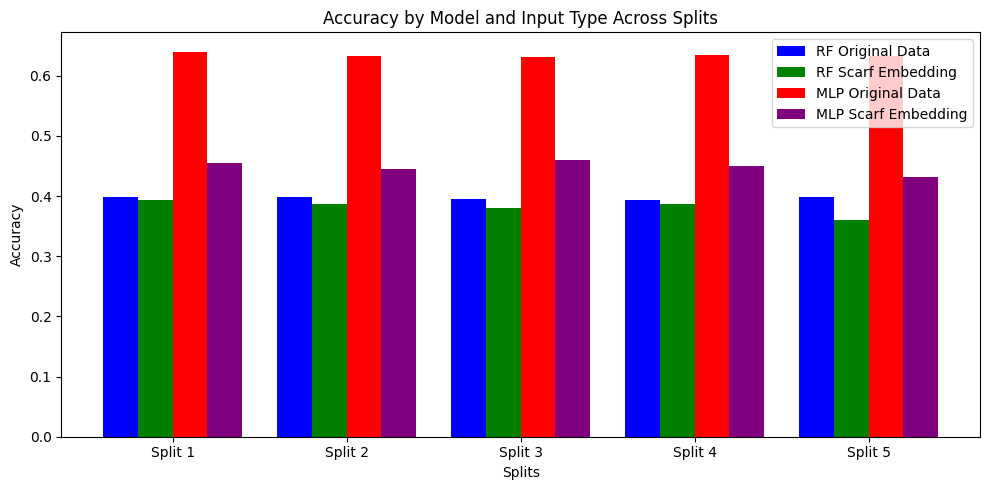

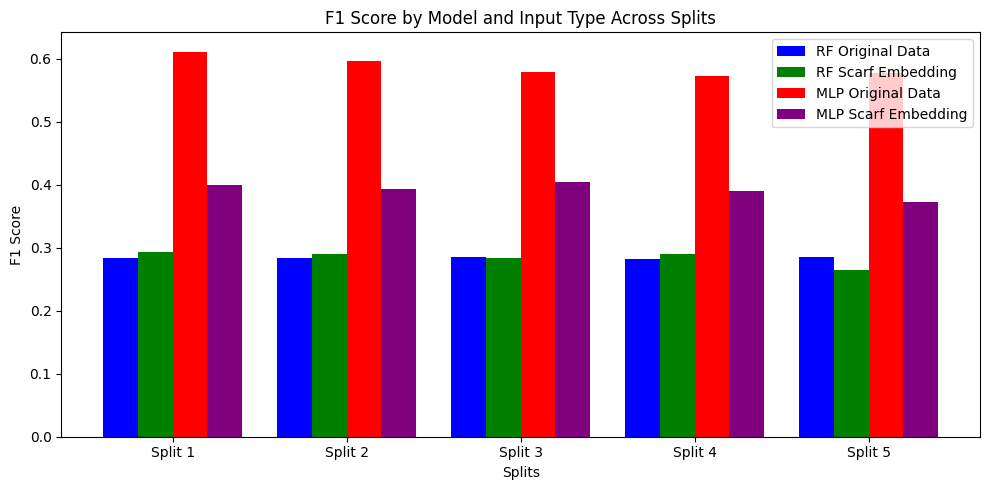

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Random Forest', 'MLP']
inputs = ['Original Data', 'Scarf Embedding']
splits = ['Split 1', 'Split 2', 'Split 3', 'Split 4', 'Split 5']

# Accuracy and F1 Score for Random Forest and MLP
accuracy_data = [
    [0.3985, 0.3980, 0.3958, 0.3934, 0.3983],  # Random Forest Original Data
    [0.3927, 0.3870, 0.3803, 0.3866, 0.3596],  # Random Forest Scarf Embedding
    [0.6401, 0.6334, 0.6306, 0.6351, 0.6332],  # MLP Original Data
    [0.4547, 0.4455, 0.4596, 0.4494, 0.4313]   # MLP Scarf Embedding
]

f1_score_data = [
    [0.2840, 0.2842, 0.2845, 0.2813, 0.2847],  # Random Forest Original Data
    [0.2931, 0.2901, 0.2836, 0.2903, 0.2650],  # Random Forest Scarf Embedding
    [0.6113, 0.5959, 0.5782, 0.5732, 0.5779],  # MLP Original Data
    [0.3995, 0.3926, 0.4046, 0.3906, 0.3733]   # MLP Scarf Embedding
]

colors = ['blue', 'green', 'red', 'purple']
labels = [
    'RF Original Data', 'RF Scarf Embedding',
    'MLP Original Data', 'MLP Scarf Embedding'
]

# Setup the bar width
bar_width = 0.2
index = np.arange(len(splits))

# Create Accuracy Plot
plt.figure(figsize=(10, 5))
for i in range(len(accuracy_data)):
    plt.bar(index + i * bar_width, accuracy_data[i], bar_width, label=labels[i], color=colors[i])

plt.xlabel('Splits')
plt.ylabel('Accuracy')
plt.title('Accuracy by Model and Input Type Across Splits')
plt.xticks(index + 1.5 * bar_width, splits)
plt.legend()

plt.tight_layout()
plt.show()

# Create F1 Score Plot
plt.figure(figsize=(10, 5))
for i in range(len(f1_score_data)):
    plt.bar(index + i * bar_width, f1_score_data[i], bar_width, label=labels[i], color=colors[i])

plt.xlabel('Splits')
plt.ylabel('F1 Score')
plt.title('F1 Score by Model and Input Type Across Splits')
plt.xticks(index + 1.5 * bar_width, splits)
plt.legend()

plt.tight_layout()
plt.show()
